In [386]:
import numpy as np
import pandas as pd

import random
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_formats = ['retina']  # or svg
%matplotlib inline
plt.style.use('ggplot')
np.set_printoptions(suppress=True)

sns.set(context='notebook', style='whitegrid')

from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import log_loss,confusion_matrix,precision_score, recall_score,accuracy_score, precision_recall_curve,f1_score, fbeta_score, roc_auc_score, roc_curve
from sklearn import svm

from ipywidgets import interactive, FloatSlider

from sklearn.model_selection import (cross_validate, cross_val_score, train_test_split, KFold, GridSearchCV)

# Fetch Customer Churn Data Set

In [387]:
df = pd.read_csv('Customer_Churn_Cleaned_Data')

In [388]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0       10000 non-null  int64  
 1   RowNumber        10000 non-null  int64  
 2   Exited           10000 non-null  int64  
 3   CreditScore      10000 non-null  int64  
 4   Age              10000 non-null  int64  
 5   Tenure           10000 non-null  int64  
 6   Balance          10000 non-null  float64
 7   NumOfProducts    10000 non-null  int64  
 8   HasCrCard        10000 non-null  int64  
 9   IsActiveMember   10000 non-null  int64  
 10  EstimatedSalary  10000 non-null  float64
 11  Germany          10000 non-null  int64  
 12  Spain            10000 non-null  int64  
 13  Male             10000 non-null  int64  
dtypes: float64(2), int64(12)
memory usage: 1.1 MB


In [389]:
df

,Unnamed: 0,RowNumber,Exited,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
0,0,1,1,619,42,2,0.00,1,1,1,101348.88,0,0,0
1,1,2,0,608,41,1,83807.86,1,0,1,112542.58,0,1,0
2,2,3,1,502,42,8,159660.80,3,1,0,113931.57,0,0,0
3,3,4,0,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,4,5,0,850,43,2,125510.82,1,1,1,79084.10,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9995,9996,0,771,39,5,0.00,2,1,0,96270.64,0,0,1
9996,9996,9997,0,516,35,10,57369.61,1,1,1,101699.77,0,0,1
9997,9997,9998,1,709,36,7,0.00,1,0,1,42085.58,0,0,0
9998,9998,9999,1,772,42,3,75075.31,2,1,0,92888.52,1,0,1


In [390]:
X = df.loc[:,'CreditScore':'Male']
y = df['Exited']

# Implementing Helper Methods used by Classification Models

In [394]:
def get_precision_recall_curve(model,y_test,X_test):
    precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, model.predict_proba(X_test)[:,1])

    plt.figure(dpi=100)
    plt.title('Precision and Recall Curves');
    plt.xlabel('Threshold (above this probability, label as churn)');
    
    plt.plot(threshold_curve, precision_curve[1:],label='precision')
    plt.plot(threshold_curve, recall_curve[1:], label='recall')
    plt.legend(loc='lower left')

In [396]:
def get_cross_val_score(model, X_train, y_train):
    kfold = KFold(n_splits=10, shuffle=True, random_state=10)
    scores = cross_val_score(model, X_train, y_train, cv=kfold)
    print('\n',scores)
    print("Mean Score (Accuracy): ", np.mean(scores))

In [395]:
def make_confusion_matrix(model,X_test,y_test,threshold=0.5):
    # Predict class 1 if probability of being in class 1 is greater than threshold
    # (model.predict(X_test) does this automatically with a threshold of 0.5)
    y_predict = (model.predict_proba(X_test)[:, 1] >= threshold)
    fraud_confusion = confusion_matrix(y_test, y_predict)
    plt.figure(dpi=80)
    sns.heatmap(fraud_confusion, cmap=plt.cm.Reds, annot=True, square=True, fmt='d',
           xticklabels=['non-churn', 'churn'],
           yticklabels=['non-churn', 'churn']);
    plt.xlabel('PREDICTION')
    plt.ylabel('ACTUAL')

In [522]:
def get_model_evaluation_scores(model,y_test,X_test):
    print('Model Evaluation Metrics: \n Accuracy: %.4f \n Precision: %.4f \n Recall: %.4f \n F1: %.4f \n F-Beta Score: %.4f \n ROC_AUC Score: %.4f'%
        (accuracy(y_test, model.predict(X_test)), 
         precision_score(y_test, model.predict(X_test)), 
         recall_score(y_test, model.predict(X_test)),
         f1_score(y_test, model.predict(X_test)),
         fbeta_score(y_test, model.predict(X_test), average='weighted', beta=2.5),
         roc_auc_score(y, model.predict_proba(X)[:, 1])
        )
     ) 

## Standardizing the inputs

Standardization is the process of putting different variables on the same scale. A variable is standardized by subtracting from it its sample mean and by dividing it by its standard deviation. After being standardized, the variable has zero mean and unit standard deviation

In [461]:
X_tran_ip = X

scaler_X = StandardScaler()
scaler_X.fit(X_tran_ip)
X_tran = scaler_X.transform(X_tran_ip)
X_tran

array([[-0.32622142,  0.29351742, -1.04175968, ..., -0.57873591,
        -0.57380915, -1.09598752],
       [-0.44003595,  0.19816383, -1.38753759, ..., -0.57873591,
         1.74273971, -1.09598752],
       [-1.53679418,  0.29351742,  1.03290776, ..., -0.57873591,
        -0.57380915, -1.09598752],
       ...,
       [ 0.60498839, -0.27860412,  0.68712986, ..., -0.57873591,
        -0.57380915, -1.09598752],
       [ 1.25683526,  0.29351742, -0.69598177, ...,  1.72790383,
        -0.57380915,  0.91241915],
       [ 1.46377078, -1.04143285, -0.35020386, ..., -0.57873591,
        -0.57380915, -1.09598752]])

# Split data and train models

Do a train/test split and fit a logistic regression and 10 nearest neighbors model.

Split data into 80% train and 20% test

In [510]:
X_train, X_test, y_train, y_test = train_test_split(X_tran, y, test_size = 0.2, random_state=25)

In [463]:
### Fit models using Logistic Regression and KNN 
lr = LogisticRegression(C = 1)
knn = KNeighborsClassifier(n_neighbors = 10)
dt_model = DecisionTreeClassifier()
rf_model = RandomForestClassifier()

lr.fit(X_train, y_train)
knn.fit(X_train, y_train)
KNeighborsClassifier(n_neighbors=10)
dt_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [464]:
import xgboost as xgb
gbm = xgb.XGBClassifier( 
                        n_estimators=30000,
                        max_depth=4,
                        objective='binary:logistic',
                        learning_rate=.05, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = gbm.fit(X_train, y_train, eval_set=eval_set, eval_metric='error',
                    early_stopping_rounds=50,verbose=False)

# accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))

C:\Users\vyasc\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


### Score models on test set using Classification Evaluation Metrics

## ROC curve
ROC plots true positive rate (recall) vs. false positive rate for a given probability decision threshold. So you should loop over a range of probability cutoffs from 1 to 0, convert a model's predicted probabilities (model.predict_proba()[:,1]) to target labels using each cutoff, and plot the results as a curve.


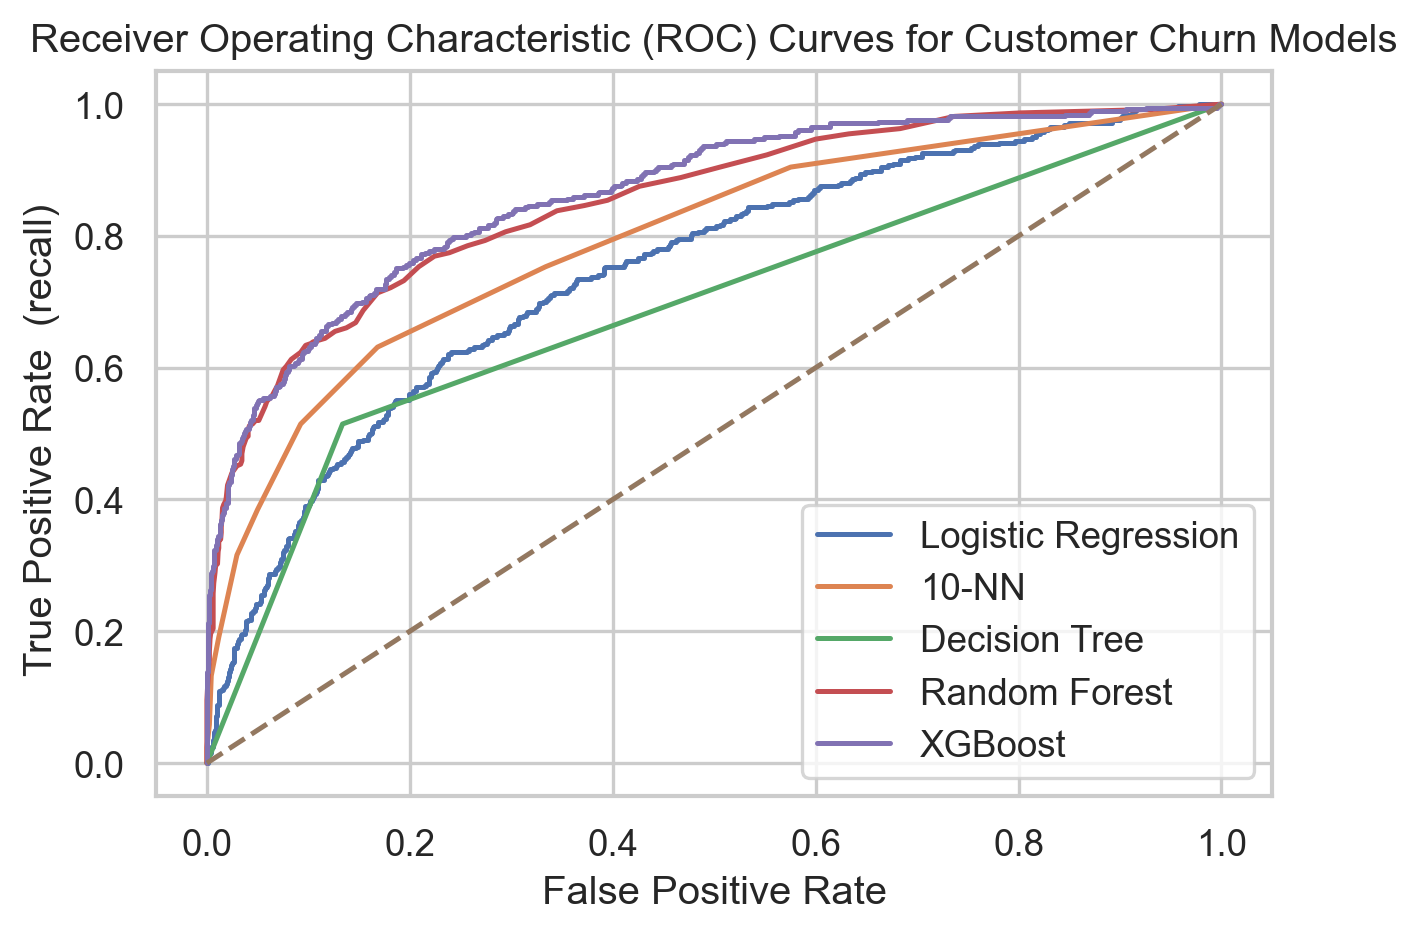

In [452]:
from sklearn.metrics import roc_curve

plt.figure(dpi=120)
fpr, tpr, _ = roc_curve(y_test, lr.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, knn.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, dt_model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

fpr, tpr, _ = roc_curve(y_test, gbm.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr)

x = np.linspace(0,1, 100000)
plt.plot(x, x, linestyle='--')

# plt.title('ROC Curve')
plt.title('Receiver Operating Characteristic (ROC) Curves for Customer Churn Models');
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate  (recall) ')
plt.legend(['Logistic Regression','10-NN', 'Decision Tree', 'Random Forest', 'XGBoost'])

In [400]:
print("Cross Validation using different models\n")

print("Logistic Regression Scores - Train followed by Test Scores for Cross Validation")
lr = LogisticRegression(C = 1)
get_cross_val_score(lr, X_train, y_train)
get_cross_val_score(lr, X_test, y_test)

print("\nK Nearest Neighbours Scores - Train followed by Test Scores for Cross Validation")
knn = KNeighborsClassifier(n_neighbors = 10)
get_cross_val_score(knn, X_train, y_train)
get_cross_val_score(knn, X_test, y_test)

print("\nDecision Tree CV Scores - Train followed by Test Scores for Cross Validation")
dt_model = DecisionTreeClassifier()
get_cross_val_score(dt_model, X_train, y_train)
get_cross_val_score(dt_model, X_test, y_test)

print("\nRandom Forest CV Scores - Train followed by Test Scores for Cross Validation")
rf_model = RandomForestClassifier()
get_cross_val_score(rf_model, X_train, y_train)
get_cross_val_score(rf_model, X_test, y_test)

Cross Validation using different models

Logistic Regression Scores - Train followed by Test Scores for Cross Validation

 [0.8     0.835   0.80875 0.8025  0.81625 0.80375 0.8     0.8     0.80125
 0.815  ]
Mean Score (Accuracy):  0.8082499999999999

 [0.79  0.83  0.81  0.845 0.845 0.815 0.78  0.835 0.84  0.81 ]
Mean Score (Accuracy):  0.8200000000000001

K Nearest Neighbours Scores - Train followed by Test Scores for Cross Validation

 [0.82375 0.85    0.835   0.8325  0.8175  0.82375 0.84125 0.82125 0.8175
 0.83375]
Mean Score (Accuracy):  0.8296249999999998

 [0.805 0.845 0.815 0.84  0.815 0.82  0.795 0.83  0.845 0.85 ]
Mean Score (Accuracy):  0.826

Decision Tree CV Scores - Train followed by Test Scores for Cross Validation

 [0.79375 0.79625 0.82    0.81125 0.7825  0.80875 0.8     0.76625 0.79125
 0.7825 ]
Mean Score (Accuracy):  0.79525

 [0.755 0.77  0.765 0.805 0.78  0.78  0.735 0.8   0.82  0.825]
Mean Score (Accuracy):  0.7835

Random Forest CV Scores - Train followed by Test S

## K Nearest Neighbours

KNN Model - 10 nearest neighbors
Model Evaluation Metrics: 
 Accuracy: 0.8350 
 Precision: 0.6351 
 Recall: 0.3615 
 F1: 0.4608 
 F-Beta Score: 0.8286 
 ROC_AUC Score: 0.5701


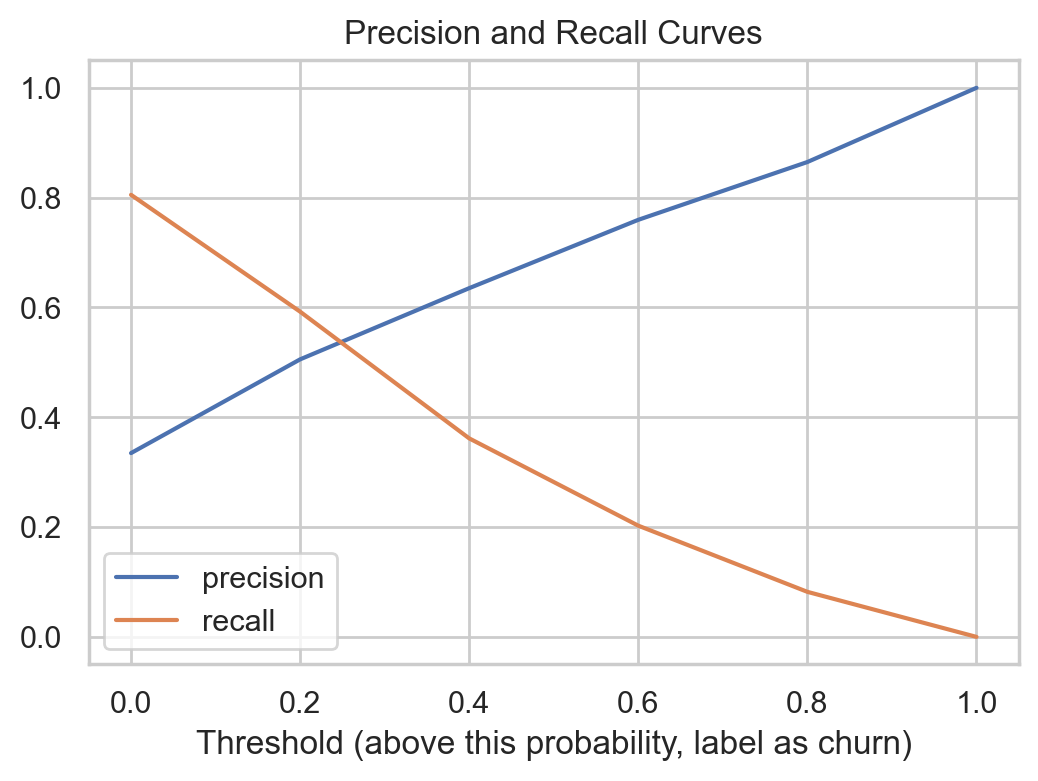

In [531]:

knn = KNeighborsClassifier()
param_grid_knn = dict(n_neighbors = np.arange(1), weights=weight_options)

knn.fit(X_train,y_train)

print('KNN Model - 10 nearest neighbors')

get_model_evaluation_scores(knn,y_test,X_test)

get_precision_recall_curve(knn,y_test,X_test)

In [468]:
interactive(lambda threshold: make_confusion_matrix(knn,X_test,y_test, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

# Logistic Regression - Baseline Classifier Model

In [530]:
lr = LogisticRegression(C = 1)
lr.fit(X_train,y_train)
print('Logistic Regression Model')
get_model_evaluation_scores(lr,y_test,X_test)

Logistic Regression Model
Model Evaluation Metrics: 
 Accuracy: 0.8100 
 Precision: 0.5325 
 Recall: 0.2103 
 F1: 0.3015 
 F-Beta Score: 0.7985 
 ROC_AUC Score: 0.5008


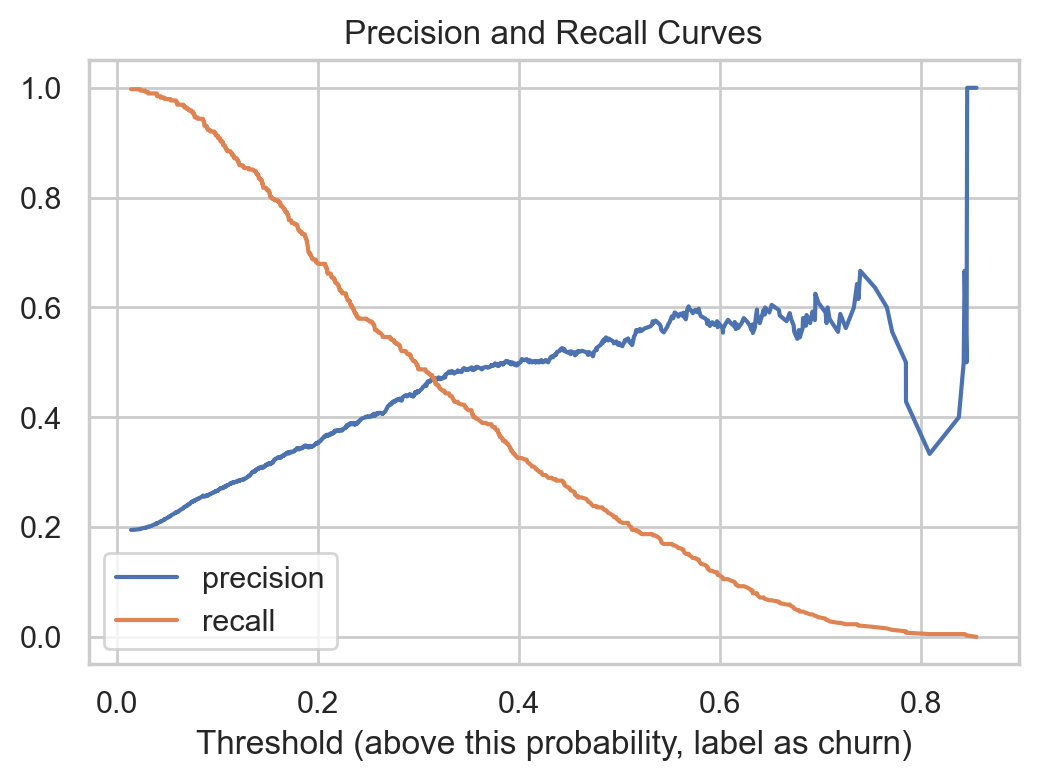

In [512]:
get_precision_recall_curve(lr,y_test,X_test)

In [406]:
interactive(lambda threshold: make_confusion_matrix(lr,X_test,y_test, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Age              10000 non-null  int64  
 2   Tenure           10000 non-null  int64  
 3   Balance          10000 non-null  float64
 4   NumOfProducts    10000 non-null  int64  
 5   HasCrCard        10000 non-null  int64  
 6   IsActiveMember   10000 non-null  int64  
 7   EstimatedSalary  10000 non-null  float64
 8   Germany          10000 non-null  int64  
 9   Spain            10000 non-null  int64  
 10  Male             10000 non-null  int64  
dtypes: float64(2), int64(9)
memory usage: 859.5 KB
Features: None
Feature: 0, Score: -0.06128
Feature: 1, Score: 0.78787
Feature: 2, Score: -0.06306
Feature: 3, Score: 0.17114
Feature: 4, Score: -0.06770
Feature: 5, Score: -0.01156
Feature: 6, Score: -0.54199
Feature: 7, Score: 0.02175
Featur

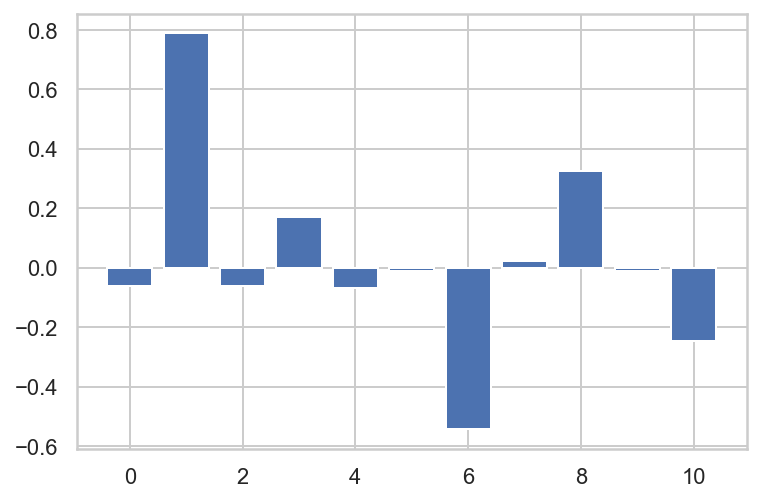

In [438]:
# logistic regression for feature importance
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot


X = df.loc[:,'CreditScore':'Male']
print('Features:', X.info())
lr = LogisticRegression(C = 1)
lr.fit(X_train,y_train)

# get importance
importance = lr.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

## Decision Tree Classifier

In [529]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train,y_train)

print('Decision Tree Classifier Model')
get_model_evaluation_scores(dt_model,y_test,X_test)

Decision Tree Classifier Model
Model Evaluation Metrics: 
 Accuracy: 0.8045 
 Precision: 0.4987 
 Recall: 0.5026 
 F1: 0.5006 
 F-Beta Score: 0.8046 
 ROC_AUC Score: 0.5053


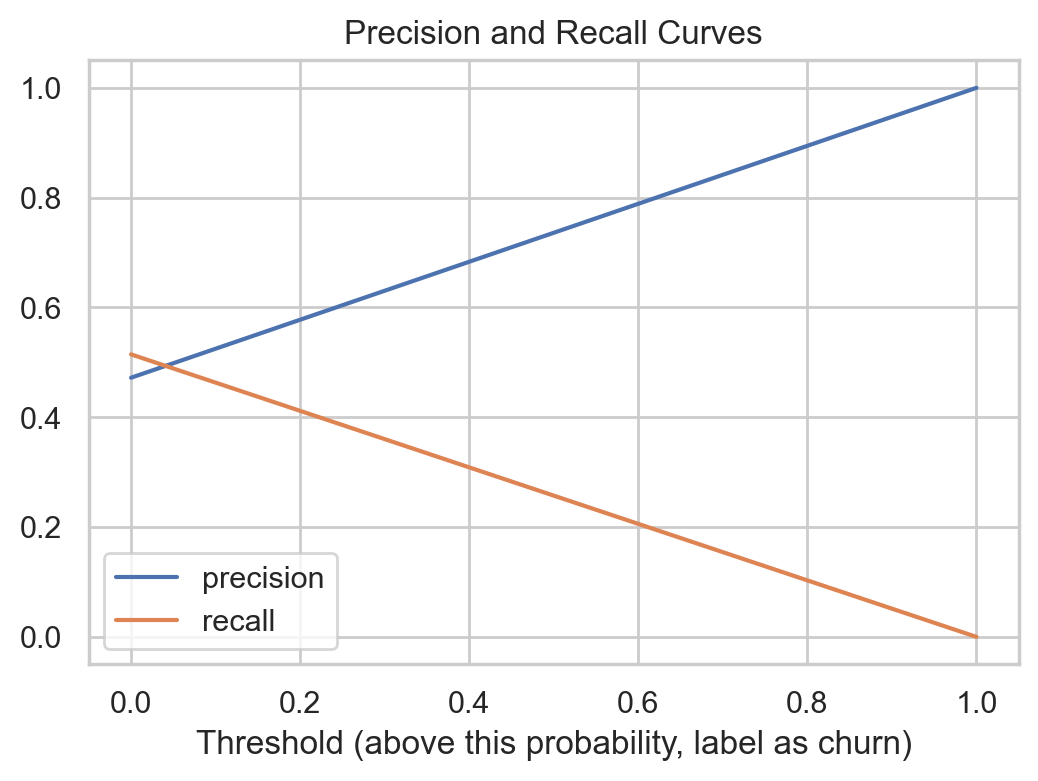

In [408]:
get_precision_recall_curve(dt_model,y_test,X_test)

In [472]:
interactive(lambda threshold: make_confusion_matrix(dt_model,X_test,y_test, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

## Random Forest Classifier

In [526]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train,y_train)

print('Random Forest Classifier validation')

get_model_evaluation_scores(rf_model,y_test,X_test)

Random Forest Classifier validation
Model Evaluation Metrics: 
 Accuracy: 0.8715 
 Precision: 0.7759 
 Recall: 0.4795 
 F1: 0.5927 
 F-Beta Score: 0.8669 
 ROC_AUC Score: 0.3592


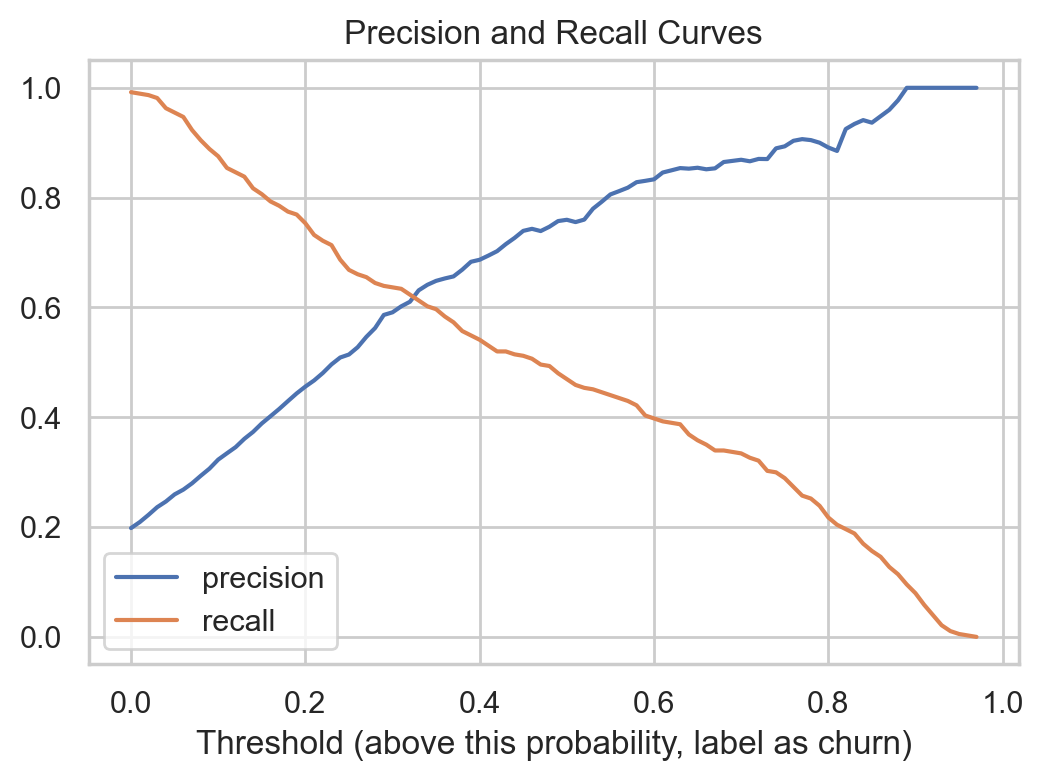

In [411]:
get_precision_recall_curve(rf_model,y_test,X_test)

In [412]:
interactive(lambda threshold: make_confusion_matrix(rf_model,X_test,y_test, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

# Scoring Models for Elite Customers vs Non-Elite Customers

Considering optimum Recall for Elite Customers.
Looking into Precision when it comes to non-elite customers.

In [489]:
X_new = df.loc[:,'CreditScore':'Male']
y_new = df['Exited']

In [490]:
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(X_new, y_new, test_size = 0.2, random_state=20)

In [491]:
X_test_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 9957 to 2054
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      2000 non-null   int64  
 1   Age              2000 non-null   int64  
 2   Tenure           2000 non-null   int64  
 3   Balance          2000 non-null   float64
 4   NumOfProducts    2000 non-null   int64  
 5   HasCrCard        2000 non-null   int64  
 6   IsActiveMember   2000 non-null   int64  
 7   EstimatedSalary  2000 non-null   float64
 8   Germany          2000 non-null   int64  
 9   Spain            2000 non-null   int64  
 10  Male             2000 non-null   int64  
dtypes: float64(2), int64(9)
memory usage: 187.5 KB


In [492]:
print('Credit Score description \n',X_test_new.CreditScore.describe())

Credit Score description 
 count    2000.000000
mean      654.154500
std        94.282258
min       350.000000
25%       591.000000
50%       656.000000
75%       720.250000
max       850.000000
Name: CreditScore, dtype: float64


In [493]:
print('Balance description \n',X_test_new.Balance.describe())

Balance description 
 count      2000.000000
mean      77871.891115
std       62479.257145
min           0.000000
25%           0.000000
50%       98448.915000
75%      129409.242500
max      222267.630000
Name: Balance, dtype: float64


In [494]:
elite_mask = (X_test_new['CreditScore'] >= 750) & (X_test_new['Balance'] >= 100000)
non_elite_mask = (X_test_new['CreditScore'] <= 600) & (X_test_new['Balance'] <= 10000)

In [495]:
elite_X_test = X_test_new[elite_mask]
non_elite_X_test = X_test_new[non_elite_mask]

In [496]:
elite_y_test = y_test_new[elite_mask]
non_elite_y_test = y_test_new[non_elite_mask]

In [497]:
print(elite_y_test.shape)
print(non_elite_y_test.shape)

(166,)
(206,)


In [498]:
elite_X_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Germany,Spain,Male
1687,850,37,4,137204.77,1,1,1,28865.59,0,1,1
2780,778,40,8,104291.41,2,1,1,117507.11,0,1,1
5213,752,29,4,129514.99,1,1,1,102930.46,1,0,1
998,811,28,4,167738.82,2,1,1,9903.42,1,0,0
1080,766,38,7,130933.74,1,0,1,2035.94,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
9365,802,29,9,127414.55,1,1,1,134459.12,0,0,1
8679,791,35,5,129828.58,1,1,1,181918.26,1,0,1
2146,850,49,5,122486.47,1,0,1,59748.19,0,0,1
1187,765,50,9,126547.80,1,1,1,79579.94,0,0,0


In [528]:
get_model_evaluation_scores(rf_model,elite_y_test,elite_X_test)

Model Evaluation Metrics: 
 Accuracy: 0.5783 
 Precision: 0.1803 
 Recall: 0.3548 
 F1: 0.2391 
 F-Beta Score: 0.5867 
 ROC_AUC Score: 0.3592


In [503]:
print('Confusion Matrix \nElite Customers with Threshold = 0.24')
interactive(lambda threshold: make_confusion_matrix(rf_model,elite_X_test,elite_y_test, threshold), threshold=(0.0,1.0,0.02))

Confusion Matrix 
Elite Customers with Threshold = 0.24


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

In [514]:
print('Confusion Matrix \nNon-Elite Customers with Threshold = 0.64')
interactive(lambda threshold: make_confusion_matrix(rf_model,non_elite_X_test, non_elite_y_test, threshold), threshold=(0.0,1.0,0.02))

Confusion Matrix 
Non-Elite Customers with Threshold = 0.64


interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

# Gradient Boosting using XGBoost

In [505]:
import xgboost as xgb
gbm = xgb.XGBClassifier( 
                        n_estimators=20000,
                        max_depth=5,
                        objective='binary:logistic', #new objective
                        learning_rate=0.08, 
                        subsample=.8,
                        min_child_weight=3,
                        colsample_bytree=.8
                       )

eval_set=[(X_train,y_train),(X_test,y_test)]
fit_model = gbm.fit( 
                    X_train, y_train, 
                    eval_set=eval_set,
                    eval_metric='error', #new evaluation metric: classification error (could also use AUC, e.g.)
                    early_stopping_rounds=50,
                    verbose=False
                   )

accuracy_score(y_test, gbm.predict(X_test, ntree_limit=gbm.best_ntree_limit))

C:\Users\vyasc\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\vyasc\anaconda3\lib\site-packages\xgboost\core.py:105: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


0.8765

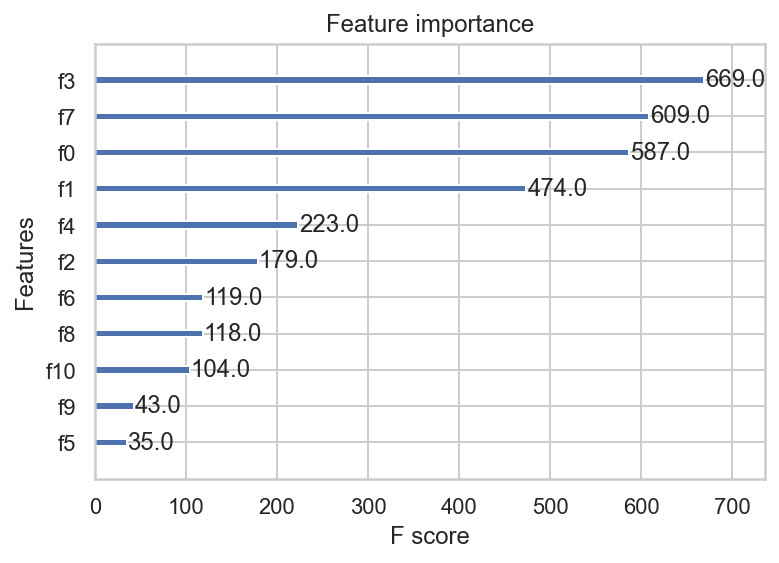

In [506]:
# XG Boost - Feature Importance
# get importance
importance = xgb.plot_importance(gbm)

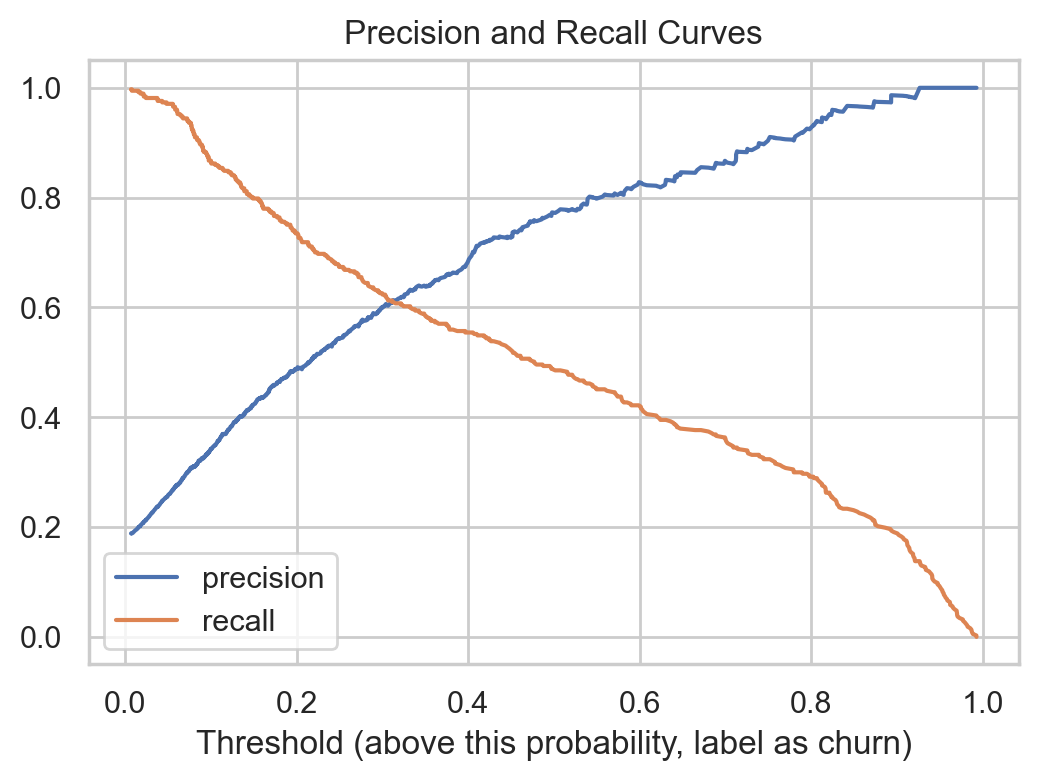

In [507]:
get_precision_recall_curve(gbm,y_test,X_test)

In [527]:
get_model_evaluation_scores(gbm,y_test,X_test)

Model Evaluation Metrics: 
 Accuracy: 0.8930 
 Precision: 0.8548 
 Recall: 0.5436 
 F1: 0.6646 
 F-Beta Score: 0.8891 
 ROC_AUC Score: 0.3729


In [509]:
interactive(lambda threshold: make_confusion_matrix(gbm,X_test,y_test, threshold), threshold=(0.0,1.0,0.02))

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…